<div>
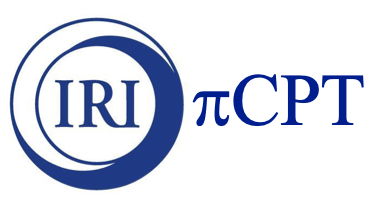
</div>

## sv1.7 (22 May 2020)
## Produce seasonal (un)calibrated forecasts and assess associated skill 


#### Requires: 
CPTv16.5.2+

#### Authors: 
Ángel G. Muñoz (agmunoz@iri.columbia.edu), Andrew W. Robertson (awr@iri.columbia.edu), Cuihua Li (OCP), Simon J. Mason (simon@iri.columbia.edu)

#### Acknowledgements: 
Rémi Cousin (IRI) for key Ingrid code development and support.
Xandre Chourio (IRI) for Windows and code support, and testing.
James Doss-Gollin (Columbia Water Center) developed the original download Python functions.
Part of the effort to develop PyCPT is funded by the Columbia World Project "Adapting Agriculture to Climate Today, for Tomorrow" (ACToday), and NOAA MAPP's projects NA18OAR4310275 (Muñoz) and NA16OAR4310145 (Robertson).

#### Version log
* This version now reads station data from the DL, and can run CPT in an automated way with it, but still doesn't have all plot functionality. --AGM 13 Sep 2019
* Started simplifying functions, wrote readGrADSctl function; added functions to create the NextGen files for det skill assessment and plotting --AGM, Sep 2019
* Fixed bug with plotting functions when selecting a subset of the seasons, and added start time for forecast file in CPT script -- AGM, July 1st 2019
* Added VQ and UQ from CFSv2. User can now select the seasons to visualize in the skill and EOF maps. Fixed bug related to coordinate selection in CHIRPS, TRMM and CPC. -- AGM, June 13th 2019
* First Notebook seasonal version -- AGM, May 7th 2019
* Several PyCPT sub-seasonal versions (through v1.2) --see logs in that version 2018-present
* First iPython sub-seasonal version (Jupyter Notebook) -- AWR, 24 Jun 2018
* First similar version (BASH for CFSv2) by Muñoz and Chourio for the OLE2 -- 12 Dec 2010 

#### Version log
See version.log in Github

#### Workflow
<div>
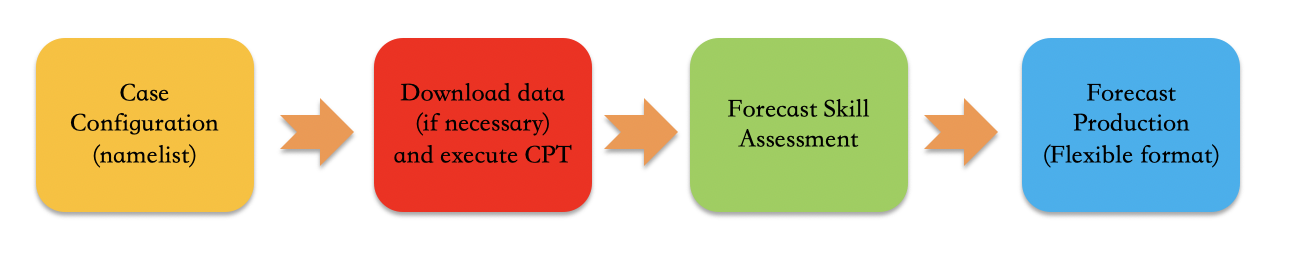
</div>

#### Input:
* Predictor is rainfall from S2S ECMWF (no realtime), or NCEP CFSv2 (realtime), or SubX GEFS (realtime)
* Predictand is either rainfall total or frequency of rainy days from TRMM (3B42 v7) or CPC Unified or IMD

#### Output:
* Several skill maps for assessment of deterministic forecast AND forecast maps, in the output folder.
* CPT scripts used to assess skill, in the scripts folder.
* Downloaded input files, in the input folder.

#### Notes:
1. Old data in the input folder is deleted at the beginning of the process!

### Namelist section

In [1]:
########Work name (name of the work folder; e.g., one word followed by "_seasonal":)
work='IAS_seasonal'

########Model (choose one, a subset or all models: 
#CanSIPSv2*, CMC1-CanCM3, CMC2-CanCM4, COLA-RSMAS-CCSM3, COLA-RSMAS-CCSM4*, 
#GFDL-CM2p1, GFDL-CM2p5-FLOR-A06*, GFDL-CM2p5-FLOR-B01*, NASA-GEOSS2S*, NCAR-CESM1, NCEP-CFSv2*)
#The ones with "*" are producing operation#al forecasts, the others are frozen. 
#CanSIPSv2 forecasts are ONLY AVAILABLE after Aug 2019!!!!
#models=['CanSIPSv2', 'COLA-RSMAS-CCSM4', 'GFDL-CM2p5-FLOR-A06', 'GFDL-CM2p5-FLOR-B01', 'NASA-GEOSS2S', 'NCEP-CFSv2']
models=['CanSIPSv2', 'COLA-RSMAS-CCSM4']

########Obs (choose between CPC-CMAP-URD, CHIRPS, TRMM, CPC, Chilestations)
obs='CHIRPS'
station=False

########MOS method (choose between None, PCR, CCA)
MOS='CCA'

########Predictand (choose between PRCP, RFREQ)
PREDICTAND='PRCP'

########Predictor (choose between GCM's PRCP, VQ, UQ)
#VQ and UQ only works with models=['NCEP-CFSv2']
PREDICTOR='PRCP'

########Target seasons and related parameters
##If more targets, increase the arrays accordingly
mons=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
#mons=['Dec']
tgtii=['1.5','1.5','1.5','1.5','1.5','1.5','1.5','1.5','1.5','1.5','1.5','1.5']  #S: start for the DL
tgtff=['3.5','3.5','3.5','3.5','3.5','3.5','3.5','3.5','3.5','3.5','3.5','3.5']   #S: end for the DL
#for now, just write the target period (for DL)
tgts=['Feb-Apr','Mar-May','Apr-Jun','May-Jul','Jun-Aug','Jul-Sep','Aug-Oct','Sep-Nov','Oct-Dec','Nov-Jan','Dec-Feb','Jan-Mar'] 
#tgts=['Jan-Mar']
#Start and end of the training period: (must be >1982 for NMME models. Because of CanSIPSv2, probably end in 2018)
tini=1982
tend=2010

########Forecast date  
monf='Dec' 	# Initialization month 
fyr=2019 	# Forecast year

########Switches:
force_download = True   #force download of data files, even if they already exist locally

########Spatial domain for predictor
# nla1=15 	# Northernmost latitude
# sla1=-15 	# Southernmost latitude
# wlo1=25 	# Westernmost longitude
# elo1=40 	# Easternmost longitude
# # Spatial domain for predictand
# nla2=-1 	# Northernmost latitude
# sla2=-3 	# Southernmost latitude
# wlo2=28 	# Westernmost longitude
# elo2=31 	# Easternmost longitude

# ########Spatial domain for predictor
nla1=30 	# Northernmost latitude
sla1=-1 	# Southernmost latitude
wlo1=-120 	# Westernmost longitude
elo1=-45 	# Easternmost longitude
# Spatial domain for predictand
nla2=30 	# Northernmost latitude
sla2=-1 	# Southernmost latitude
wlo2=-120 	# Westernmost longitude
elo2=-45 	# Easternmost longitude

In [2]:
########Some folder and file options:
# Working directory --it should exist!!!
workdir = '/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/iri-pycpt/'
# PATH to CPT root directory
cptdir='/Users/agmunoz/Documents/Angel/CPT/CPT/16.5.2/'

print("PyCPT folder is:")
%cd $workdir
!mkdir -p $work

PyCPT folder is:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/iri-pycpt


### End of namelist section  (do not modify anything below this line)

#### Load Libraries

In [3]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import subprocess
from pycpt_functions_seasonal import *
from scipy.stats import t
from sklearn.linear_model import LogisticRegression
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import calendar
print("Python libraries loaded")
print("Now in the work folder:")
%cd $work
workdir = os.getcwd()
(rainfall_frequency,threshold_pctle,wetday_threshold,obs_source,hdate_last,mpref,L,ntrain,fprefix)=setup_params(PREDICTOR,PREDICTAND,obs,MOS,tini,tend)

Python libraries loaded
Now in the work folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/iri-pycpt/IAS_seasonal
Predictand is Rainfall Total (mm)


In [4]:
print("Creating working folders, if not already there...")
print("Work directory is:")
%cd $workdir
!mkdir -p input
!mkdir -p output
!mkdir -p scripts
!rm -Rf scripts/*

# Set up CPT environment
os.environ["CPT_BIN_DIR"] = cptdir
print("CPT environment loaded...")
#print("CPT version is "+str(wetday_threshold))

Creating working folders, if not already there...
Work directory is:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/iri-pycpt/IAS_seasonal
CPT environment loaded...


## Check if domains are ok --if you don't like them, go back to the namelist and modify them

Training period: 1982-2010
Forecast initialized on: Dec 2019


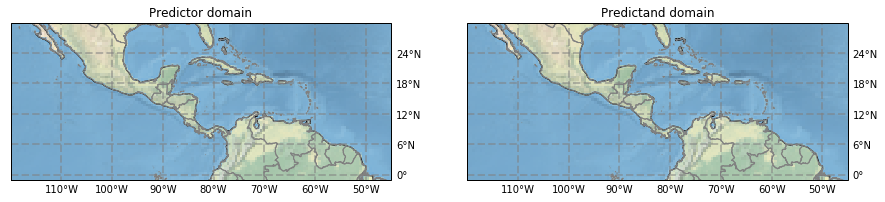

In [5]:
print("Training period: "+str(tini)+"-"+str(tend))
print("Forecast initialized on: "+monf+" "+str(fyr))

#Plot geographical domains
pltdomain(wlo1,elo1,nla1,sla1,wlo2,elo2,nla2,sla2)

# Download data if necessary, and run CPT

In [6]:
#If downloadling data from several models, this section might take a while to be done
for model in models:
    print('')
    print('')
    print('\033[1m----Starting process for '+model+'----\033[0;0m')
    for mo in range(len(mons)):
        mon=mons[mo]
        tar=tgts[mo]
        tgti=tgtii[mo]
        tgtf=tgtff[mo]
        print("New folder:")
        %cd $workdir/input

        print('Preparing CPT files for \033[1m'+model+'\033[0;0m. Target: \033[1m'+tar+'\033[0;0m - Initialization \033[1m'+mon+'\033[0;0m...')
        PrepFiles(fprefix, PREDICTAND, threshold_pctle, tini, tend, wlo1, wlo2,elo1, elo2, sla1, sla2, nla1, nla2, tgti, tgtf, mon, monf, fyr, os, wetday_threshold, tar, model, obs_source, hdate_last, force_download,station)
 
        print("New folder:")
        %cd $workdir/scripts

        CPTscript(model,PREDICTAND, mon,monf, fyr, tini,tend,nla1,sla1,wlo1,elo1,nla2,sla2,wlo2,elo2,fprefix,mpref,tar,ntrain,MOS,station)

        print('Executing CPT for \033[1m'+model+'\033[0;0m. Target: \033[1m'+tar+'\033[0;0m - Initialization \033[1m'+mon+'\033[0;0m...')
        try:
            subprocess.check_output(cptdir+'CPT.x < params > CPT_log_'+model+'_'+tar+'_'+mon+'.txt',stderr=subprocess.STDOUT, shell=True)
        except subprocess.CalledProcessError as e:
            print(e.output.decode())
            raise
        print('----------------------------------------------')
        print('Calculations for Target: \033[1m'+tar+'\033[0;0m - Initialization \033[1m'+mon+'\033[0;0m completed!')

        print('See output folder, and check scripts/CPT_log_'+model+'_'+tar+'_'+mon+'.txt for log')
        print('\033[1mQuick error report from CPT (if any):\033[0;0m')
        with open('CPT_log_'+model+'_'+tar+'_'+mon+'.txt', "r") as fp:
            for line in lines_that_contain("Error:", fp):
                print (line)
        print('----------------------------------------------')
        print('----------------------------------------------')

print('')
print('')
print('')
print('\033[1mPROCESS COMPLETED \033[0;0m')



----Starting process for CanSIPSv2----
New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/iri-pycpt/IAS_seasonal/input
Preparing CPT files for CanSIPSv2. Target: Feb-Apr - Initialization Jan...

 Hindcasts URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.CanSIPSv2/.HINDCAST/.MONTHLY/.prec/SOURCES/.Models/.NMME/.CanSIPSv2/.FORECAST/.MONTHLY/.prec/appendstream/S/%280000%201%20Jan%201982-2010%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/%5BM%5D/average/Y/-1/30/RANGEEDGES/X/-120/-45/RANGEEDGES/30/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  988k    0  988k    0     0  13521      0 --:--:--  0:01:14 --:--:-- 169094      0 --:--:--  0:00:46 --:--:-- 13167      0 --:--:--  0:00:51 --:--:-- 14188
Hindcasts file ready to go
-------------------------------------------

100  988k    0  988k    0     0  13472      0 --:--:--  0:01:15 --:--:-- 17779--:--  0:00:03 --:--:--   353   0 --:--:--  0:00:15 --:--:-- 12859    0  11510      0 --:--:--  0:00:21 --:--:-- 133390  12957      0 --:--:--  0:01:07 --:--:-- 13354   0  13237      0 --:--:--  0:01:11 --:--:-- 16489
Hindcasts file ready to go
----------------------------------------------

 Obs (Rainfall) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.UCSB/.CHIRPS/.v2p0/.daily-improved/.global/.0p25/.prcp/30/mul/T/(1%20Jan%201982)/(31%20Dec%202010)/RANGE/T/%28May-Jul%29/seasonalAverage/Y/%28-1%29/%2830%29/RANGEEDGES/X/%28-120%29/%28-45%29/RANGEEDGES/-999/setmissing_value/%5BX/Y%5D%5BT%5Dcptv10.tsv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.4M    0 14.4M    0     0   534k      0 --:--:--  0:00:27 --:--:--  522k   0   131k      0 --:--:--  0:00:08 --:--:--  263k
Obs:precip file read

100  988k    0  988k    0     0  12707      0 --:--:--  0:01:19 --:--:-- 16934   0   8974      0 --:--:--  0:00:07 --:--:-- 1444632      0 --:--:--  0:00:13 --:--:-- 13400     0  12042      0 --:--:--  0:00:23 --:--:-- 13504   0 --:--:--  0:00:30 --:--:-- 14130
Hindcasts file ready to go
----------------------------------------------

 Obs (Rainfall) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.UCSB/.CHIRPS/.v2p0/.daily-improved/.global/.0p25/.prcp/30/mul/T/(1%20Jan%201982)/(31%20Dec%202010)/RANGE/T/%28Aug-Oct%29/seasonalAverage/Y/%28-1%29/%2830%29/RANGEEDGES/X/%28-120%29/%28-45%29/RANGEEDGES/-999/setmissing_value/%5BX/Y%5D%5BT%5Dcptv10.tsv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.4M    0 14.4M    0     0   484k      0 --:--:--  0:00:30 --:--:--  582k     0  39099      0 --:--:--  0:00:07 --:--:-- 63385     0 --:--:--  0:00:15 --:--:--  520k-:--:--  0:00:

100  988k    0  988k    0     0  13207      0 --:--:--  0:01:16 --:--:-- 197743k    0  103k    0     0  10159      0 --:--:--  0:00:10 --:--:-- 14213      0 --:--:--  0:00:12 --:--:--  7514
Hindcasts file ready to go
----------------------------------------------

 Obs (Rainfall) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.UCSB/.CHIRPS/.v2p0/.daily-improved/.global/.0p25/.prcp/30/mul/T/(1%20Jan%201982)/(31%20Dec%202010)/RANGE/T/%28Nov-Jan%29/seasonalAverage/Y/%28-1%29/%2830%29/RANGEEDGES/X/%28-120%29/%28-45%29/RANGEEDGES/-999/setmissing_value/%5BX/Y%5D%5BT%5Dcptv10.tsv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.0M    0 14.0M    0     0   531k      0 --:--:--  0:00:26 --:--:--  495k    0 6658k    0     0   503k      0 --:--:--  0:00:13 --:--:--  575k
Obs:precip file ready to go
----------------------------------------------

 Forecast URL: 

 https://iridl.

100  988k    0  988k    0     0   103k      0 --:--:--  0:00:09 --:--:--  111k 0   6517      0 --:--:--  0:00:01 --:--:--  6511488k    0  488k    0     0  97734      0 --:--:--  0:00:05 --:--:-- 98661
Hindcasts file ready to go
----------------------------------------------

 Obs (Rainfall) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.UCSB/.CHIRPS/.v2p0/.daily-improved/.global/.0p25/.prcp/30/mul/T/(1%20Jan%201982)/(31%20Dec%202010)/RANGE/T/%28Feb-Apr%29/seasonalAverage/Y/%28-1%29/%2830%29/RANGEEDGES/X/%28-120%29/%28-45%29/RANGEEDGES/-999/setmissing_value/%5BX/Y%5D%5BT%5Dcptv10.tsv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.4M  100 14.4M    0     0  3319k      0  0:00:04  0:00:04 --:--:-- 3521k
Obs:precip file ready to go
----------------------------------------------

 Forecast URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CCSM4/

100  988k    0  988k    0     0    99k      0 --:--:--  0:00:09 --:--:--  135k 61074      0 --:--:--  0:00:03 --:--:-- 61074 0  70201      0 --:--:--  0:00:04 --:--:-- 70187
Hindcasts file ready to go
----------------------------------------------

 Obs (Rainfall) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.UCSB/.CHIRPS/.v2p0/.daily-improved/.global/.0p25/.prcp/30/mul/T/(1%20Jan%201982)/(31%20Dec%202010)/RANGE/T/%28May-Jul%29/seasonalAverage/Y/%28-1%29/%2830%29/RANGEEDGES/X/%28-120%29/%28-45%29/RANGEEDGES/-999/setmissing_value/%5BX/Y%5D%5BT%5Dcptv10.tsv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.4M  100 14.4M    0     0  2863k      0  0:00:05  0:00:05 --:--:-- 3157k
Obs:precip file ready to go
----------------------------------------------

 Forecast URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CCSM4/.MONTHLY/.prec/S/%280000%20

100  988k    0  988k    0     0   149k      0 --:--:--  0:00:06 --:--:--  191k121k
Hindcasts file ready to go
----------------------------------------------

 Obs (Rainfall) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.UCSB/.CHIRPS/.v2p0/.daily-improved/.global/.0p25/.prcp/30/mul/T/(1%20Jan%201982)/(31%20Dec%202010)/RANGE/T/%28Nov-Jan%29/seasonalAverage/Y/%28-1%29/%2830%29/RANGEEDGES/X/%28-120%29/%28-45%29/RANGEEDGES/-999/setmissing_value/%5BX/Y%5D%5BT%5Dcptv10.tsv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.0M  100 14.0M    0     0  3122k      0  0:00:04  0:00:04 --:--:-- 3122k
Obs:precip file ready to go
----------------------------------------------

 Forecast URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CCSM4/.MONTHLY/.prec/S/%280000%201%20Dec%202019%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/%5BM%5D/average/Y/

## Skill Analysis

Present folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/iri-pycpt/IAS_seasonal/output


FileNotFoundError: [Errno 2] No such file or directory: '../output/CanSIPSv2_PRCPPRCP_CCA_Ignorance_Aug-Oct_Jan.ctl'

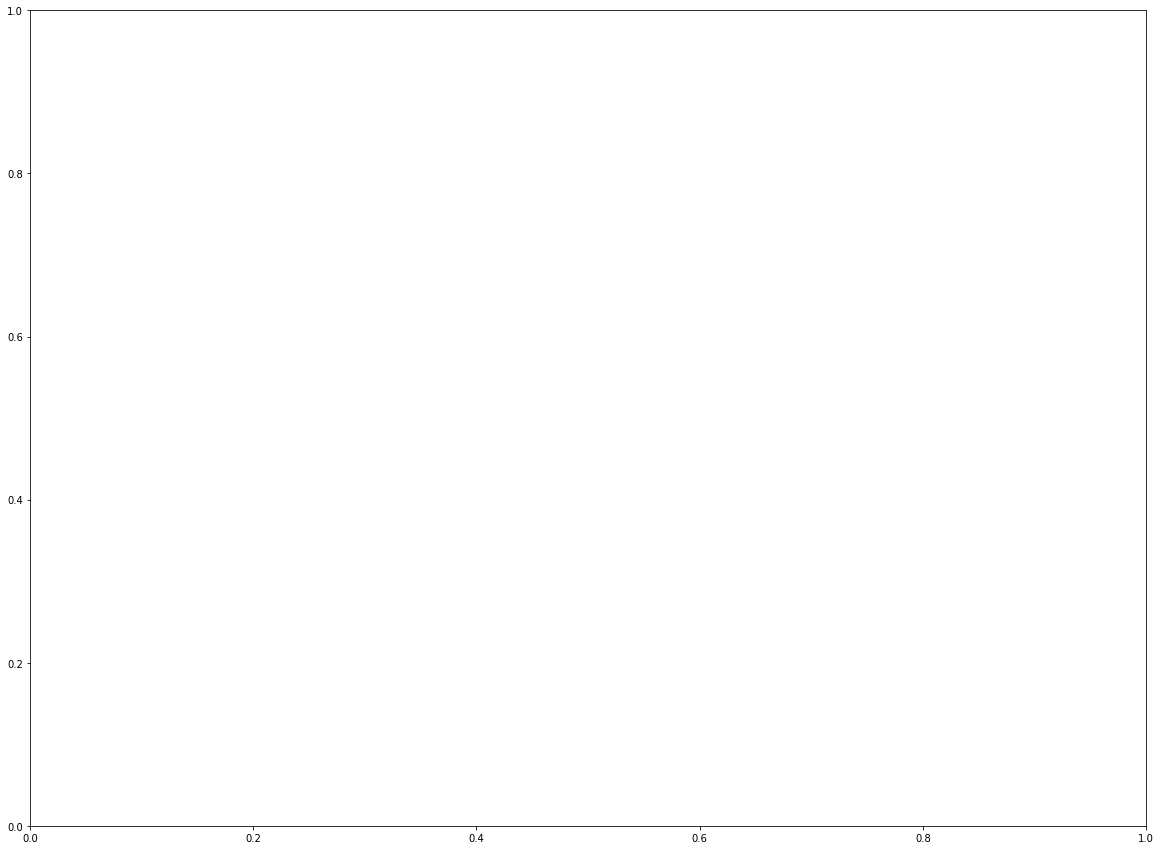

In [7]:
#####Choose metrics (options are: 'Pearson','Spearman','2AFC','RocAbove','RocBelow'):
met=('Ignorance','RPSS','GROC')
#met=('Spearman','2AFC','RocAbove','RocBelow','Ignorance','RPSS','GROC')
monss=['Aug-Oct','Mar-May','Apr-Jun','Sep-Nov']   #Needs to be any of the seasons computed.
#monss=['Jan-Mar'] 

print("Present folder:")
%cd $workdir/output

# Skill scores loop
plt.rcParams.update({'font.size': 10})
for ime in met:
    pltmap(models,PREDICTAND,ime,wlo2,elo2,sla2,nla2,fprefix,mpref,tgts,mons,monss)   
    print('')
    print("\033[1m"+ime+"\033[0;0m")
    plt.savefig(ime+".png")
    #plt.close()
    plt.show()
    print('')


## EOF Analysis (only available if MOS=PCR or CCA)

Present folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_seasonal/output


Mode 1


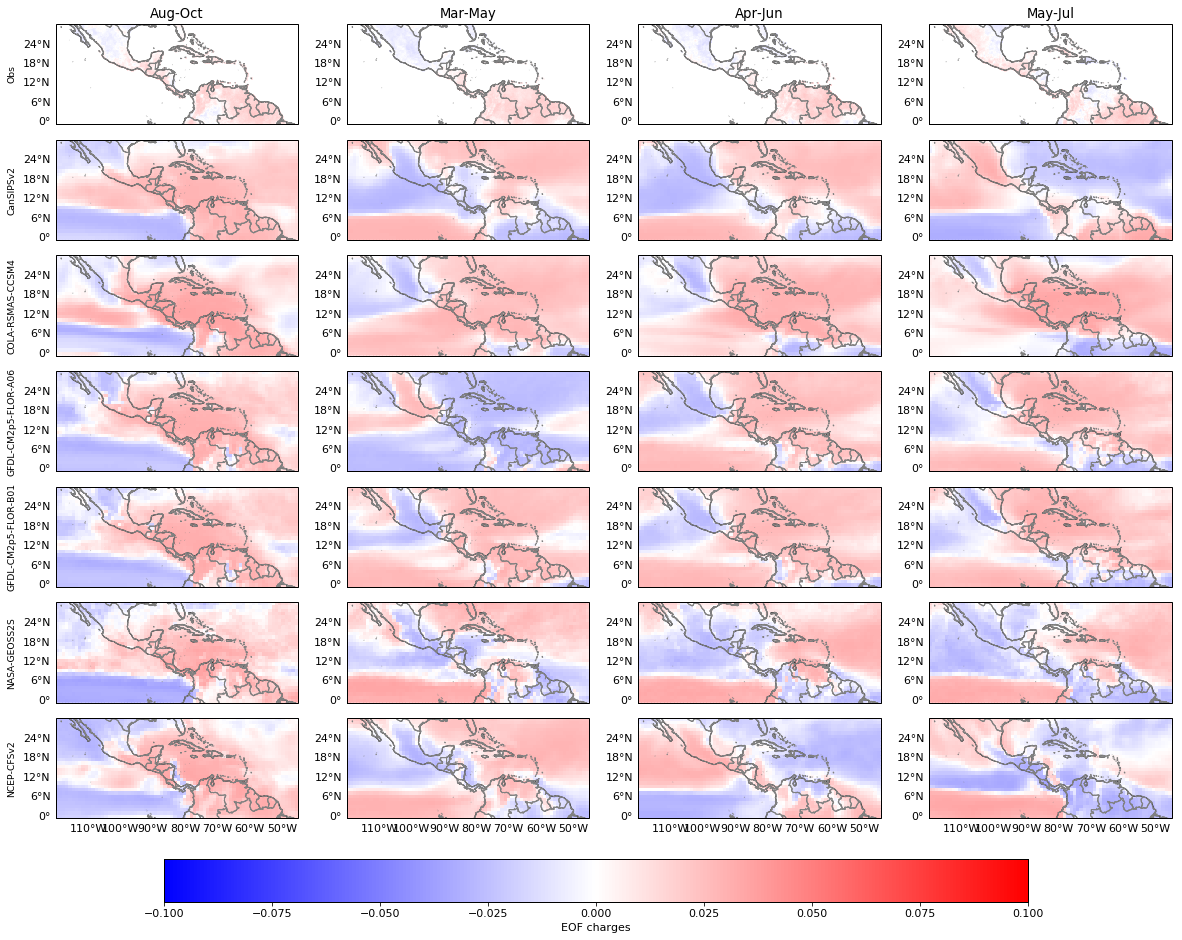

Mode 2


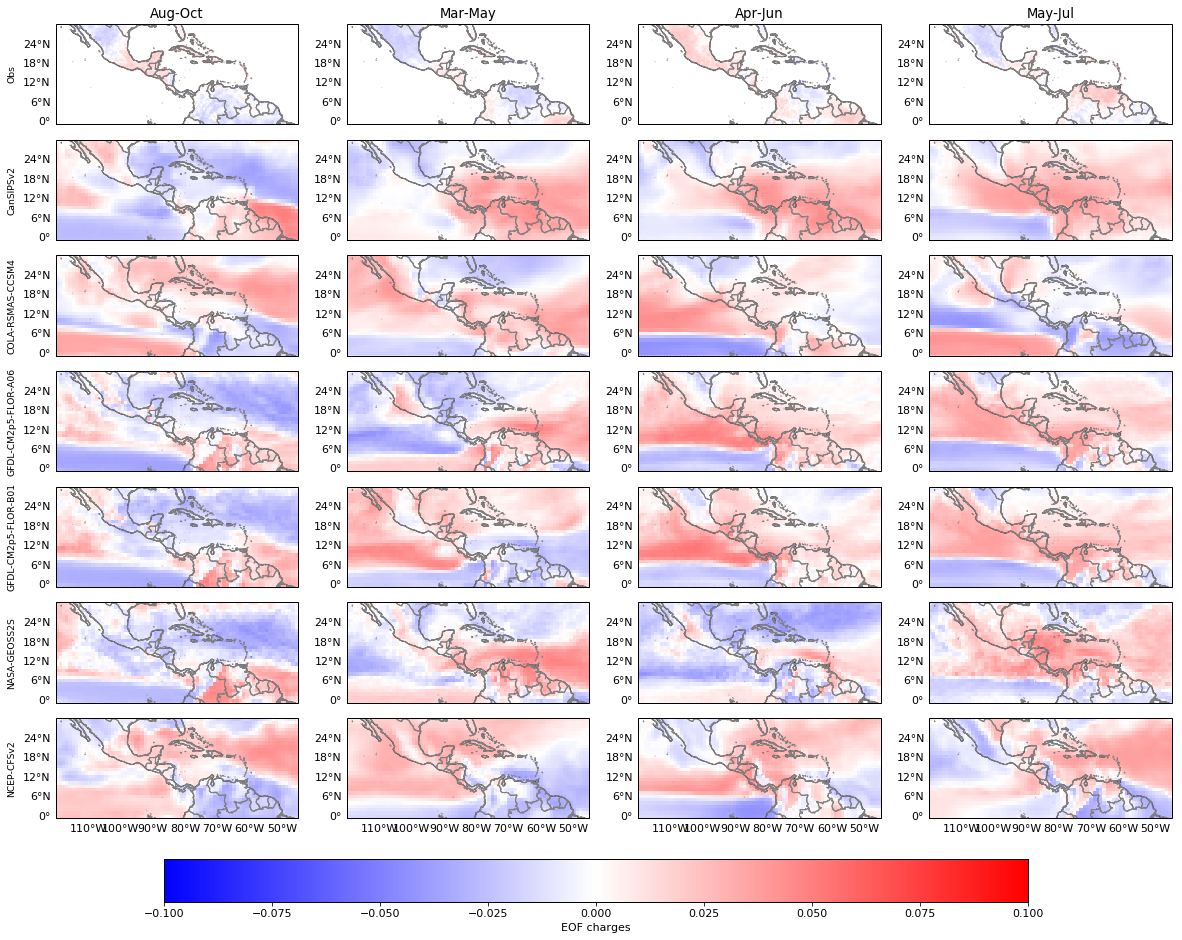

Mode 3


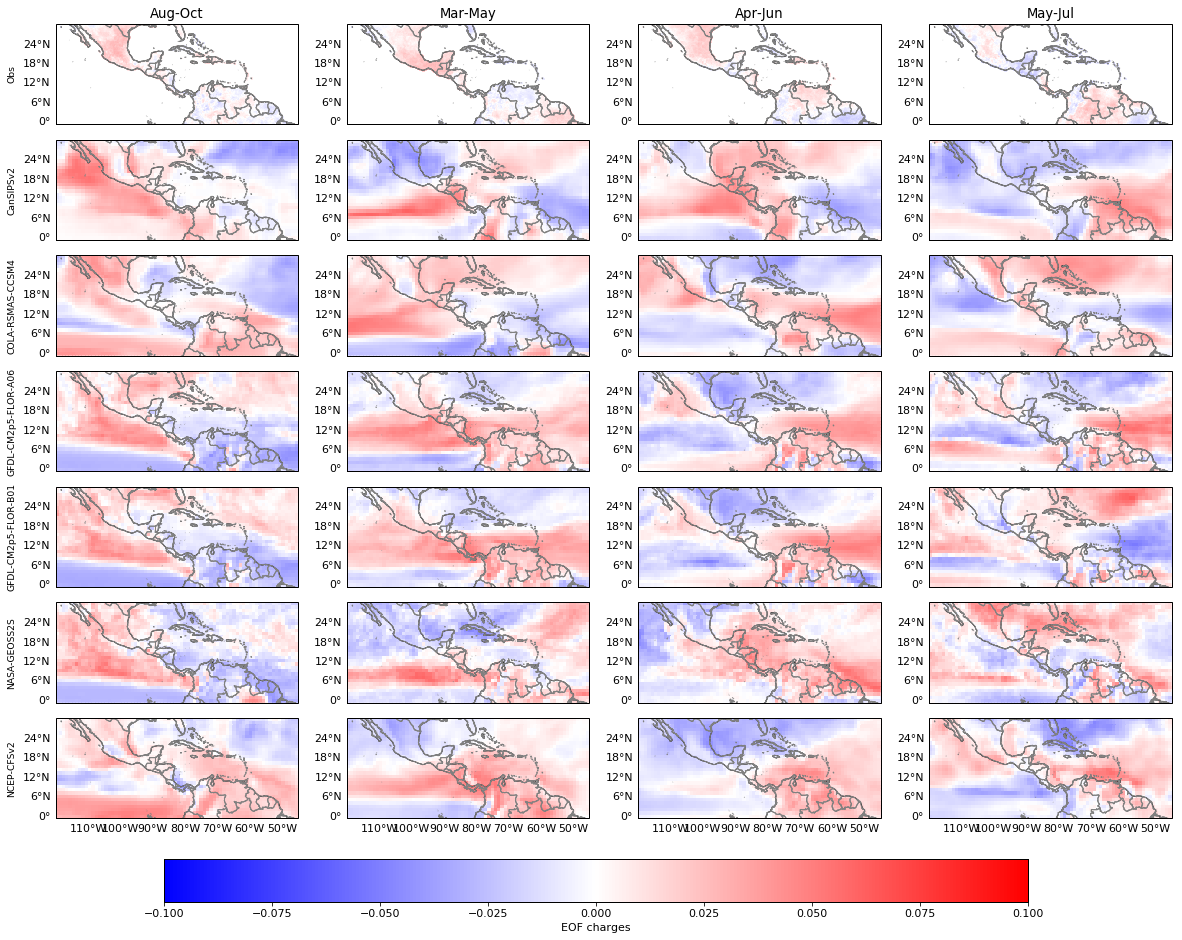

In [24]:
monss=['Aug-Oct','Mar-May','Apr-Jun','May-Jul']   #Needs to be any of the seasons computed.
#monss=['Mar-May'] 
nmodes=3

print("Present folder:")
%cd $workdir/output
print('')
print('')

if MOS=='None':
    print("To compute EOFs you need to choose MOS=PCR or MOS=CCA")
else:
    # Skill scores loop
    plt.rcParams.update({'font.size': 11})
    for imod in range(nmodes):
        plteofs(models,PREDICTAND,imod,nmodes,wlo2,elo2,sla2,nla2,fprefix,mpref,tgts, mons,monss)   
        print("\033[1mMode "+str(imod+1))
        plt.show()

## Multi-model ensemble: NextGen

In [ ]:
#Indicate models to be included in the NextGen ensemble:
#models=['CMC2-CanCM4']
models=['CanSIPSv2', 'COLA-RSMAS-CCSM4']#, 'GFDL-CM2p5-FLOR-A06', 'GFDL-CM2p5-FLOR-B01', 'NASA-GEOSS2S', 'NCEP-CFSv2']

In [ ]:
print('\033[1m----Assessing skill for NextGen----\033[0;0m')
model='NextGen'
MOS='None'   #we're changing here to no MOS to assess skill of NextGen
print('Using the following model(s) in the NextGen cocktail: \n\n'+str(models))
print('')
print('')
print('')

for mo in range(len(mons)):
    mon=mons[mo]
    tar=tgts[mo]
    tgti=tgtii[mo]
    tgtf=tgtff[mo]
    print("New folder:")
    %cd $workdir/input

    print('Preparing CPT files for \033[1m'+model+'\033[0;0m. Target: \033[1m'+tar+'\033[0;0m - Initialization \033[1m'+mon+'\033[0;0m...')
    NGensemble(models,fprefix,PREDICTAND,mpref,'FCST_xvPr',tar,mon,tgti,tgtf,monf,fyr)
    
    print("New folder:")
    %cd $workdir/scripts

    #We run CPT with a NoMOS configuration, BUT producing a MOS=mpref (e.g., CCA) file!
    CPTscript(model,PREDICTAND, mon,monf, fyr, tini,tend,nla1,sla1,wlo1,elo1,nla2,sla2,wlo2,elo2,fprefix,mpref,tar,ntrain,MOS,station)

    print('Executing CPT for \033[1m'+model+'\033[0;0m. Target: \033[1m'+tar+'\033[0;0m - Initialization: \033[1m'+mon+'\033[0;0m...')
    try:
        subprocess.check_output(cptdir+'CPT.x < params > CPT_log_'+model+'_'+tar+'_'+mon+'.txt',stderr=subprocess.STDOUT, shell=True)
    except subprocess.CalledProcessError as e:
        print(e.output.decode())
        raise
    print('----------------------------------------------')
    print('Calculations completed for \033[1m'+tar+'\033[0;0m - Initialization: \033[1m'+mon+'\033[0;0m')
    print('See output folder, and check scripts/CPT_log_'+model+'_'+tar+'_'+mon+'.txt for errors')
    print('\033[1mQuick error report from CPT (if any):\033[0;0m')
    with open('CPT_log_'+model+'_'+tar+'_'+mon+'.txt', "r") as fp:
        for line in lines_that_contain("Error:", fp):
            print (line)
        print('----------------------------------------------')
        print('----------------------------------------------')
    print('Generating FlexForecast files for \033[1m'+model+'\033[0;0m. Target: \033[1m'+tar+'\033[0;0m - Initialization: \033[1m'+mon+'\033[0;0m...')
    NGensemble(models,fprefix,PREDICTAND,mpref,'FCST_mu',tar,mon,tgti,tgtf,monf,fyr)    
    NGensemble(models,fprefix,PREDICTAND,mpref,'FCST_var',tar,mon,tgti,tgtf,monf,fyr) 
    print('----------------------------------------------')

print('')
print('')
print('')
print('\033[1mPROCESS COMPLETED \033[0;0m')

In [ ]:
#####Choose metrics (options are: 'Pearson','Spearman','2AFC','RocAbove','RocBelow','Ignorance','RPSS','GROC'):
met=('Ignorance','RPSS','GROC')
monss=['Aug-Oct','Mar-May','Apr-Jun','Sep-Nov']   #Needs to be any of the seasons computed.
#monss=['Mar-May'] 
models=['NextGen','CanSIPSv2', 'COLA-RSMAS-CCSM4', 'GFDL-CM2p5-FLOR-A06', 'GFDL-CM2p5-FLOR-B01', 'NASA-GEOSS2S', 'NCEP-CFSv2']

print("Present folder:")
%cd $workdir/output

# Skill scores loop
plt.rcParams.update({'font.size': 10})
for ime in met:
    pltmap(models,PREDICTAND,ime,wlo2,elo2,sla2,nla2,fprefix,mpref,tgts,mons,monss)   
    
    print('')
    print("\033[1m"+ime+"\033[0;0m")
    plt.show()
    print('')

In [27]:
print("Present folder:")
%cd $workdir/output
#Usually not needed:
#ensemblefiles(modelo,work)

Present folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_seasonal/output


### Flexible Forecasts

Folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/iri-pycpt/IAS_seasonal/output


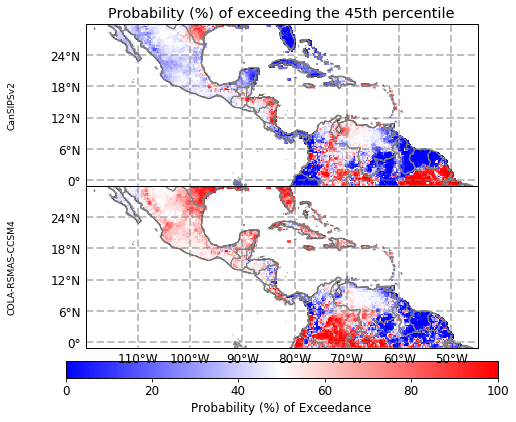

In [26]:
flexformat_threshold = 0.45 #threshold for the flexible format map --here is just a scalar (only one target season)
ffthres_ispctl=True  #If True, flex format threshold is a percentile: 0.001 - 0.999

print("Folder:")
%cd $workdir/output
plt.rcParams.update({'font.size': 12})
pltmapff(models,PREDICTAND,flexformat_threshold,ffthres_ispctl,ntrain,wlo2,elo2,sla2,nla2,fprefix,mpref,monf,fyr,mons,tgts)
#plt.savefig("ProbFcst_Flex.pdf", dpi=300)

Folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/iri-pycpt/IAS_seasonal/output


<Figure size 1080x1080 with 0 Axes>

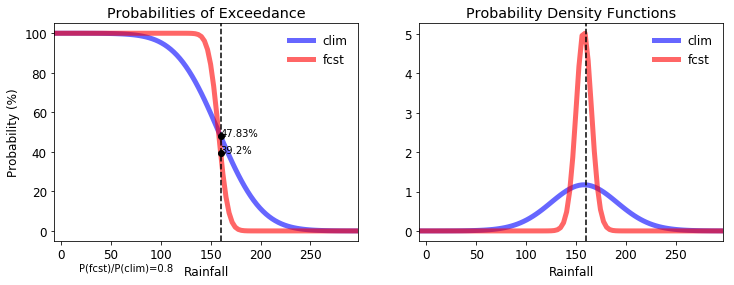

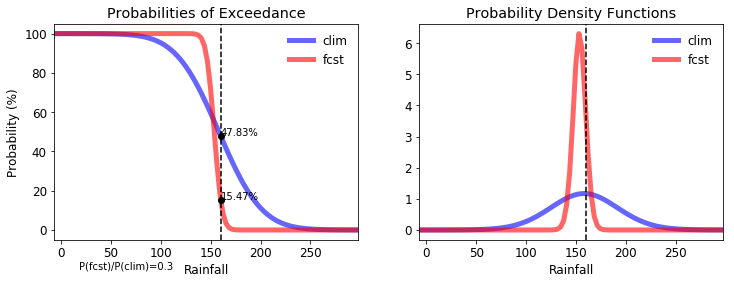

In [27]:
flexformat_threshold = 160 #threshold for the flexible format map --here is just a scalar (only one target season)
ffthres_ispctl=False  #If True, flex format threshold is a percentile: 0.001 - 0.999
lon=-75.
lat=5.
 
print("Folder:")
%cd $workdir/output
plt.rcParams.update({'font.size': 12})
pltprobff(models,PREDICTAND,flexformat_threshold,ntrain,lon,lat,wlo2,elo2,sla2,nla2,fprefix,mpref,monf,fyr,mons,tgts)
plt.savefig("ProbExceed.pdf", dpi=300)